# Footprint calling and plotting of a single DHS

This notebook shows an example of to how call footprints on a single region and plot the results. This code recreates **Extended Data Fig. 1** from [Vierstra2020]_.

The plotting performed in this example relies on the python package `genome-tools`, which provides an assortment of ways to plot genomic data. You can find a short tutorial in the form of a python notebook [here](https://github.com/jvierstra/genome-tools/blob/master/examples/UsageExamples.ipynb) on the various features.

In [1]:
import numpy as np
import pandas as pd
import scipy as sc
import scipy.stats as stats

import pysam

from genome_tools import bed, genomic_interval
from footprint_tools import cutcounts
from footprint_tools.modeling import bias, predict, dispersion
from footprint_tools.stats import fdr, windowing, utils

In [2]:
# We can grab the FASTA, BAM and dispersion model files remotely with the API
fasta_file = "https://resources.altius.org/~jvierstra/projects/footprinting.2020/hg38.all.fa"

base_url="https://resources.altius.org/~jvierstra/projects/footprinting.2020/per.dataset/CD20+-DS18208/"
bam_file=base_url + "reads.bam"
disp_model_file=base_url + "dm.json"

!curl https://resources.altius.org/~jvierstra/projects/footprinting.2020/vierstra_et_al.6mer-model.txt -o vierstra_et_al.6mer-model.txt
bias_model_file = "vierstra_et_al.6mer-model.txt" 

# This is the genomic region to plot data
interval = genomic_interval('chr19', 48363826, 48364602)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 95802  100 95802    0     0  1439k      0 --:--:-- --:--:-- --:--:-- 1417k


## Perform footprint detection

In [3]:
counts_reader = cutcounts.bamfile(bam_file)
fasta_reader = pysam.FastaFile(fasta_file)
dm = dispersion.load_dispersion_model(disp_model_file)
bm = bias.kmer_model(bias_model_file)

predictor = predict.prediction(counts_reader, fasta_reader, bm, half_win_width = 5, smoothing_half_win_width = 50, smoothing_clip = 0.01)
(obs_counts, exp_counts, win_counts) = predictor.compute(interval)
    
# Compute expected counts
# Note: windowed counts are used to generated expected counts
# and not used directly in statistical testing
obs = obs_counts['+'][1:] + obs_counts['-'][:-1]
exp = exp_counts['+'][1:] + exp_counts['-'][:-1]
win = win_counts['+'][1:] + win_counts['-'][:-1]

# Per-nucleotide p-values
pvals = dm.p_values(exp, obs)

# Windowed p-values with Stouffer's Z
winpvals_func = lambda x: windowing.stouffers_z(np.ascontiguousarray(x), 3)
winpvals = np.array(winpvals_func(pvals))

# Resample from expected distributions for emperical adjustment of p-values for multiple testing
_, pvals_null = dm.sample(exp, 1000)
winpvals_null = np.apply_along_axis(winpvals_func, 0, pvals_null)
fdr = fdr.emperical_fdr(winpvals_null, winpvals)

# Call footprints at 0.01 FDR
fps = [genomic_interval(interval.chrom, interval.start+x, interval.start+y) 
    for x, y in utils.segment(np.array(fdr), 0.01, 3, decreasing=True) ]

## Plot genomic footprinting data

In [4]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as mgridspec
import matplotlib.ticker as mticker
import matplotlib.collections as mcollections

from genome_tools.plotting import signal_plot, add_scale_bar

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

def make_nb_plot(expected, observed, dm, ax, lo = 0, hi = 125):
    """Plots the dispersion model negative binomial distribution"""
    
    x = np.arange(lo, hi)
    
    mu = dm.fit_mu(expected)
    r = dm.fit_r(expected)
    p = r/(r+mu)

    y = sc.stats.nbinom.pmf(x, r, p)
    ax.plot(x, y, label = "Expected cleavage rate")
    ax.fill_between(x[:int(observed)], 0, y[:int(observed)], edgecolor = 'none', label="Prob. observed")
    
    ax.set_xlim(left = lo, right = hi)
    
    ax.set_xlabel("Cleavages")
    ax.set_ylabel("Density")

    [ax.spines[loc].set_color("none") for loc in ["top", "right"]]
    ax.xaxis.set_ticks_position("bottom")
    ax.xaxis.set_tick_params(direction = "out")
    ax.xaxis.set(major_locator = mticker.MaxNLocator(4))
    
    ax.yaxis.set_ticks_position("left")
    ax.yaxis.set_tick_params(direction = "out")
    ax.yaxis.set(major_locator = mticker.MaxNLocator(3))
    ax.set_ylim(bottom=0)

In [5]:
# Positions to highlight with distribution
pos = [278, 536]

# Footprint thresholds to plot
thresholds=[0.05, 0.01, 0.001, 0.0001]

Text(0, 0.5, 'Footprints (FDR)')

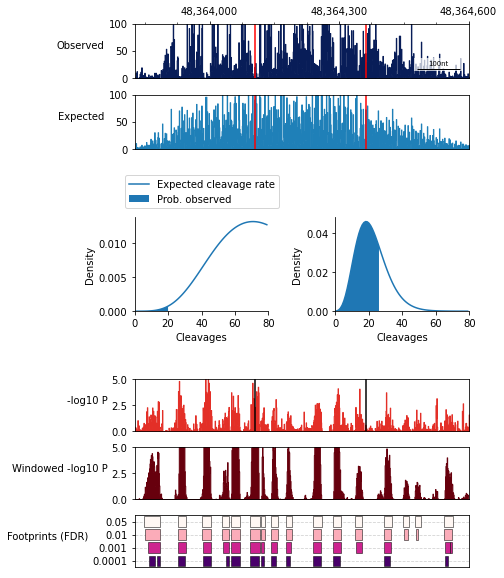

In [6]:
fig = plt.figure()
fig.set_size_inches(6, 10)

gs = mgridspec.GridSpec(3, 1, height_ratios=[2, 1.5, 3], wspace=0.2, hspace=0.5)

# Plot observed/expected cleavages

gs_cleavage = mgridspec.GridSpecFromSubplotSpec(2,1, subplot_spec = gs[0,:], hspace = 0.3)

cmap = discrete_cmap(4, "YlGnBu_r")

ax_obs = fig.add_subplot(gs_cleavage[0,:])

signal_plot(interval, obs, ax_obs, facecolor=cmap(0), edgecolor=cmap(0), xaxis='top')
ax_obs.set_ylim(top=100)
add_scale_bar(ax_obs)

[ax_obs.axvline(i+interval.start, color='red') for i in pos]
ax_obs.set_ylabel("Observed", rotation=0, ha="right")

ax_exp = fig.add_subplot(gs_cleavage[1,:])
signal_plot(interval, exp, ax_exp, facecolor=cmap(1), edgecolor=cmap(1), xaxis=None)
ax_exp.set_ylim(top=100)


[ax_exp.axvline(i+interval.start, color='red') for i in pos]
ax_exp.set_ylabel("Expected", rotation=0, ha="right")

# Plot negative binomials

gs_nb = mgridspec.GridSpecFromSubplotSpec(1, len(pos), subplot_spec = gs[1,:], hspace = 0, wspace=0.5)

for i, j in enumerate(pos):
    ax_nb = fig.add_subplot(gs_nb[0,i])
    make_nb_plot(exp[j], obs[j], dm, ax_nb, hi=80)
    if i==0:
        ax_nb.legend(loc=9, bbox_to_anchor=[0.5, 1.5])

        
# # Plot cleavage statistics and footprint calls

gs_stats = mgridspec.GridSpecFromSubplotSpec(3,1, subplot_spec = gs[2,:], hspace = 0.3)

cmap = discrete_cmap(4, "Reds")

ax_log10p = fig.add_subplot(gs_stats[0,:])
signal_plot(interval, -np.log10(pvals), facecolor=cmap(2), edgecolor=cmap(2), ax=ax_log10p, xaxis=None)
ax_log10p.set_ylim(top=5)

[ax_log10p.axvline(i+interval.start, color='k') for i in pos]
ax_log10p.set_ylabel("-log10 P", rotation=0, ha="right")

ax_winlog10p = fig.add_subplot(gs_stats[1,:])
signal_plot(interval, -np.log10(winpvals), facecolor=cmap(3), edgecolor=cmap(3), ax=ax_winlog10p, xaxis=None)
ax_winlog10p.set_ylim(top=5)

ax_winlog10p.set_ylabel("Windowed -log10 P", rotation=0, ha="right")

# Plot footprints
ax_fps = fig.add_subplot(gs_stats[2,:])

cmap=discrete_cmap(len(thresholds), "RdPu_r")

for i, thresh in enumerate(sorted(thresholds)):
    fps = [genomic_interval(interval.chrom, interval.start+x, interval.start+y) for x, y in utils.segment(np.array(fdr, dtype=np.float64), thresh, 3, decreasing=True) ]
    starts=[fp.start for fp in fps]
    widths=[len(fp) for fp in fps]

    coll = mcollections.BrokenBarHCollection(zip(starts, widths), (i+0.1, 0.8), facecolors=cmap(i), edgecolors='k', linewidths=0.5)
    ax_fps.add_collection(coll)
    
    ax_fps.axhline(i+0.5, color='lightgrey', ls='dashed', lw=0.8, zorder=-1)

ax_fps.set_xlim(interval.start, interval.end)
ax_fps.set_ylim(0, 4)
ax_fps.xaxis.set_visible(False)

ax_fps.yaxis.set_ticks(np.arange(len(thresholds))+0.5)
ax_fps.yaxis.set_ticklabels(sorted(thresholds))

ax_fps.set_ylabel("Footprints (FDR)", rotation=0, ha="right")

## Auto-correlation analysis of *p*-values

The following computes the Pearson's correlations between null p-values at offsets up to 25 bp.

In [7]:
m, n = pvals_null.shape

ts = range(0, 26)

cor_mat = np.ones((m, len(ts)), dtype = float)
for i in range(m):
    for t in ts[1:]:        
        x = pvals_null[:-t, i]
        y = pvals_null[t:,i]
        cor_mat[i, t] = np.corrcoef(x, y)[0, 1]

err = np.percentile(cor_mat, [10, 90], axis = 0)

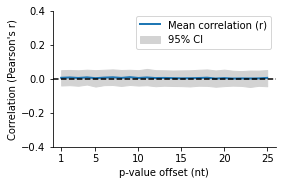

In [8]:
fig, ax = plt.subplots()

ax.plot(ts[1:], np.mean(cor_mat, axis = 0)[1:], lw = 2, label = "Mean correlation (r)")
ax.fill_between(ts[1:], err[0,1:], err[1,1:], color = "lightgrey", label = "95% CI")

ax.axhline(0.0, ls = "--", color = 'black')

ax.set_xlim(0, 26)
ax.set_ylim(-0.4, 0.4)

ax.set_xlabel("p-value offset (nt)")
ax.set_ylabel("Correlation (Pearson's r)")

[ax.spines[loc].set_color("none") for loc in ["top", "right"]]

ax.xaxis.set_ticks([1, 5, 10, 15, 20, 25])
ax.xaxis.set_ticks_position("bottom")
ax.xaxis.set_tick_params(direction = "out")

ax.yaxis.set_ticks_position("left")
ax.yaxis.set_tick_params(direction = "out")
ax.yaxis.set(major_locator = mticker.MaxNLocator(4))
    
ax.legend()

fig.set_size_inches(4, 2.5)

plt.show()

## Plot obserbved and null *p*-value distributions

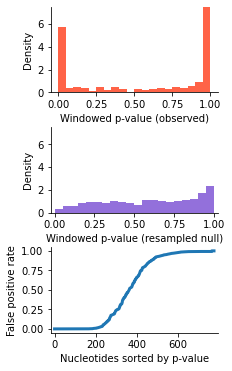

In [9]:
fig = plt.figure()
fig.set_size_inches(3, 6)

gs = mgridspec.GridSpec(3, 1, hspace=0.4)

ax = fig.add_subplot(gs[0, 0])
ax.hist(winpvals, bins = np.arange(0, 1.05, 0.05), lw = 0, facecolor = "tomato", density = True)
ax.set_ylim(bottom = 0, top = 7.5)

ax.set_xlabel("Windowed p-value (observed)")
ax.set_ylabel("Density")

[ax.spines[loc].set_color('none') for loc in ["right", "top"]]
ax.xaxis.set(ticks_position = 'bottom')
ax.xaxis.set_tick_params(direction = "out")

ax.yaxis.set(ticks_position = 'left', major_locator = mticker.MaxNLocator(4))
ax.yaxis.set_tick_params(direction = "out")

ax.set_ylim(bottom = 0, top = 7.5)

ax = fig.add_subplot(gs[1, 0])
ax.hist(winpvals_null[:,1], bins = np.arange(0, 1.05, 0.05), lw = 0, facecolor = "mediumpurple", density = True)
ax.set_ylim(bottom = 0, top = 7.5)

ax.set_xlabel("Windowed p-value (resampled null)")
ax.set_ylabel("Density")

[ax.spines[loc].set_color('none') for loc in ["right", "top"]]
ax.xaxis.set(ticks_position = 'bottom')
ax.xaxis.set_tick_params(direction = "out")

ax.yaxis.set(ticks_position = 'left', major_locator = mticker.MaxNLocator(4))
ax.yaxis.set_tick_params(direction = "out")

ax.margins(x = 0.025)

ax = fig.add_subplot(gs[2, 0])
ax.plot(np.sort(fdr), lw = 3)

[ax.spines[loc].set_color('none') for loc in ["right", "top"]]
ax.xaxis.set(ticks_position = 'bottom')
ax.xaxis.set_tick_params(direction = "out")

ax.yaxis.set(ticks_position = 'left', ticks = [ 0.0, 0.25, 0.5, 0.75, 1.0])
ax.yaxis.set_tick_params(direction = "out")

ax.margins(x = 0.025)

ax.set_xlabel("Nucleotides sorted by p-value")
ax.set_ylabel("False discovery rate")

plt.show()